<a href="https://colab.research.google.com/github/sauravvsonu/Stock-Portfolio-Optimization-using-MPT-and-LSTM/blob/main/MPT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas_datareader import data as wb
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sn
import yfinance as yf
%matplotlib inline

### Importing Data

In [134]:
stocks = input().split()
assets = [stock.upper() + '.NS' for stock in stocks]
assets

#Example: SBIN HDFC BAJFINANCE BANKBARODA ICICIBANK

sbin reliance coalindia itc bajfinance  kotakbank ncc 


['SBIN.NS',
 'RELIANCE.NS',
 'COALINDIA.NS',
 'ITC.NS',
 'BAJFINANCE.NS',
 'KOTAKBANK.NS',
 'NCC.NS']

In [135]:
assets.sort()
assets

['BAJFINANCE.NS',
 'COALINDIA.NS',
 'ITC.NS',
 'KOTAKBANK.NS',
 'NCC.NS',
 'RELIANCE.NS',
 'SBIN.NS']

In [136]:
years = float(input('No. of year data you want to analyze: '))

## Example: 5 or 8 or 10

No. of year data you want to analyze: 5


In [137]:
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days= 365 * years)
startDate

datetime.datetime(2016, 7, 7, 9, 17, 31, 636051)

In [138]:
yf.pdr_override()

In [139]:
pf_data = wb.get_data_yahoo(assets, start=startDate, end=endDate)['Adj Close']

[*********************100%***********************]  7 of 7 completed


In [140]:


pf_data


,BAJFINANCE.NS,COALINDIA.NS,ITC.NS,KOTAKBANK.NS,NCC.NS,RELIANCE.NS,SBIN.NS
Date,,,,,,,
2016-07-07,802.184631,221.617584,211.771286,744.171143,71.814140,476.784119,216.082825
2016-07-08,813.297424,218.913651,210.785309,741.726746,70.261139,472.199249,214.364380
2016-07-11,848.939392,225.375000,213.614624,758.787109,71.672951,479.004211,220.648987
2016-07-12,854.850098,222.671066,212.971603,761.879944,76.237816,484.264832,222.612930
2016-07-13,849.712463,227.587326,211.857025,773.203613,74.778938,486.846863,223.594910
...,...,...,...,...,...,...,...
2021-06-30,6015.850098,146.649994,202.699997,1705.849976,86.849998,2110.649902,419.200012
2021-07-01,5967.149902,145.649994,203.000000,1716.099976,87.150002,2097.949951,420.399994
2021-07-02,5997.750000,147.649994,202.399994,1715.150024,90.099998,2129.050049,424.399994


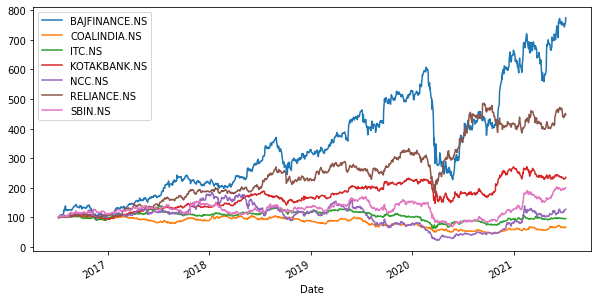

In [141]:
(pf_data / pf_data.iloc[0] * 100).plot(figsize= (10,5))
plt.show()

### Returns

In [142]:
returns = (pf_data / pf_data.shift(1)) - 1
returns

,BAJFINANCE.NS,COALINDIA.NS,ITC.NS,KOTAKBANK.NS,NCC.NS,RELIANCE.NS,SBIN.NS
Date,,,,,,,
2016-07-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-08,0.013853,-0.012201,-0.004656,-0.003285,-0.021625,-0.009616,-0.007953
2016-07-11,0.043824,0.029516,0.013423,0.023001,0.020094,0.014411,0.029317
2016-07-12,0.006962,-0.011997,-0.003010,0.004076,0.063690,0.010982,0.008901
2016-07-13,-0.006010,0.022079,-0.005233,0.014863,-0.019136,0.005332,0.004411
...,...,...,...,...,...,...,...
2021-06-30,-0.006039,0.014879,-0.002951,0.000000,0.014603,0.010944,-0.005457
2021-07-01,-0.008095,-0.006819,0.001480,0.006009,0.003454,-0.006017,0.002863
2021-07-02,0.005128,0.013732,-0.002956,-0.000554,0.033850,0.014824,0.009515


In [143]:
annual_returns = returns.mean() * 250 *100
annual_returns.values.sort()
annual_returns

BAJFINANCE.NS    -3.961957
COALINDIA.NS      2.773178
ITC.NS           19.321879
KOTAKBANK.NS     21.069050
NCC.NS           21.488065
RELIANCE.NS      35.178550
SBIN.NS          50.497892
dtype: float64

In [144]:
num_assets = len(assets)

### Random Weights

In [145]:
weights = np.random.random(num_assets)
weights /= np.sum(weights)
weights

array([0.19406582, 0.01220349, 0.14795289, 0.09460674, 0.32257823,
       0.0717058 , 0.15688703])

### Mean Annual Returns

In [146]:
np.sum(weights * returns.mean()) * 250

0.24255564997225343

### annual Variance

In [147]:
np.dot(weights.T, np.dot(returns.cov() * 250, weights))

0.08828049414969505

### annual covariance

In [148]:
np.sqrt(np.dot(weights.T,np.dot(returns.cov() * 250, weights)))

0.29712033614294237

### Correlation

In [149]:
corr_matrix = returns.corr()
corr_matrix

,BAJFINANCE.NS,COALINDIA.NS,ITC.NS,KOTAKBANK.NS,NCC.NS,RELIANCE.NS,SBIN.NS
BAJFINANCE.NS,1.000000,0.249086,0.265280,0.508728,0.384599,0.332689,0.429203
COALINDIA.NS,0.249086,1.000000,0.255146,0.197505,0.366358,0.267317,0.330383
ITC.NS,0.265280,0.255146,1.000000,0.297374,0.327581,0.225335,0.346060
KOTAKBANK.NS,0.508728,0.197505,0.297374,1.000000,0.259846,0.355882,0.343141
NCC.NS,0.384599,0.366358,0.327581,0.259846,1.000000,0.278897,0.479831
RELIANCE.NS,0.332689,0.267317,0.225335,0.355882,0.278897,1.000000,0.320438
SBIN.NS,0.429203,0.330383,0.346060,0.343141,0.479831,0.320438,1.000000


# ***Prediction Functions:***

In [150]:
# Importing Required Library

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [151]:
## Scaling the data set as required

def Scale_data_set(data):

  dataset = data.values
  # Get the number of rows to train the model on
  training_data_len = int(np.ceil( len(dataset) * .95 ))

  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(dataset)
  return training_data_len, scaled_data, dataset, scaler

In [152]:
## Creating a dataSet to be trained by LSTM

def Creating_training_data(training_data_len, scaled_data):
  # Create the training data set 
  # Create the scaled training data set
  train_data = scaled_data[0:int(training_data_len), :]
  # Split the data into x_train and y_train data sets
  x_train = []
  y_train = []

  for i in range(60, len(train_data)):
      x_train.append(train_data[i-60:i, 0])
      y_train.append(train_data[i, 0])
      
          
  # Convert the x_train and y_train to numpy arrays 
  x_train, y_train = np.array(x_train), np.array(y_train)

  # Reshape the data
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  # x_train.shape

  return x_train, y_train

In [153]:
## Training by  LSTM

def LSTM_model(x_train, y_train):
  
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  model.fit(x_train, y_train, batch_size=1, epochs=1)

  return model

In [154]:
## Predicting data using the trained value

def miscellaneous(model, training_data_len, scaled_data, dataset, scaler):
  # Create the testing data set
  # Create a new array containing scaled values from index 1543 to 2002 
  test_data = scaled_data[training_data_len - 60: , :]
  # Create the data sets x_test and y_test
  x_test = []
  y_test = dataset[training_data_len:, :]
  for i in range(60, len(test_data)):
      x_test.append(test_data[i-60:i, 0])
      
  # Convert the data to a numpy array
  x_test = np.array(x_test)

  # Reshape the data
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

  # Get the models predicted price values 
  predictions = model.predict(x_test)
  predictions = scaler.inverse_transform(predictions)

  # Get the root mean squared error (RMSE)
  rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

  return predictions, rmse

In [155]:
## Ploting the chart with predicted values

def Ploting_Prediction(predictions ,training_data_len, data, title):
  # Plot the data
  train = data[:training_data_len]
  valid = data[training_data_len:]
  valid['Predictions'] = predictions
  # Visualize the data
  plt.figure(figsize=(16,6))
  plt.title(title)
  plt.xlabel('Date', fontsize=18)
  plt.ylabel('Close Price in Rs', fontsize=18)
  plt.plot(train['Close'])
  plt.plot(valid[['Close', 'Predictions']])
  plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
  plt.show()

  return train, valid

def plot_graph_plotly(predictions ,training_data_len, data, title):
  # Plot the data
  train = data[:training_data_len]
  valid = data[training_data_len:]
  valid['Predictions'] = predictions

  #Max Sharpe Ratio
  train_data = go.Scatter(
      name='Training data',
      
      x=data.index,
      y=train['Close'],
      marker=dict(color='blue',size=5,)
  )

  #Min Vol
  Val_data = go.Scatter(
      name='Actual Value',
     
      x=valid.index,
      y=valid['Close'],
      marker=dict(color='green',size=5,)
  )

  #Random portfolio
  Prediction_data = go.Scatter(
      name='Predicted Data',
      
      x=valid.index,
      y=valid['Predictions'],
      marker=dict(color='red',size=5,)
  )

  data = [train_data, Val_data, Prediction_data]

  layout = go.Layout(
      title = title,
      yaxis = dict(title='Close Price in Rs'),
      xaxis = dict(title='Date'),
      showlegend = True,
      legend = dict(
          x = .83, y = 0, traceorder='normal',
          bgcolor='#E2E2E2',
          bordercolor='black',
          borderwidth=2),
      width=980,
      height=500)

  fig = go.Figure(data=data, layout=layout)
  fig.show()

  return train, valid

In [156]:
##  Compiling all functions to one functions

def Stock_prediction(data, title):
  training_data_len, scaled_data, dataset, scaler = Scale_data_set(data)
  x_train, y_train = Creating_training_data(training_data_len, scaled_data)
  model = LSTM_model(x_train, y_train)
  predictions, rmse = miscellaneous(model, training_data_len, scaled_data, dataset, scaler)
  train, valid = plot_graph_plotly(predictions ,training_data_len, data, title)

  return train, valid, rmse, predictions 

## Sending Data for Prediction:

In [157]:
data = {}
for st in assets:
  data['{}'.format(st)] = pf_data.filter([st])

In [158]:
pf_data

,BAJFINANCE.NS,COALINDIA.NS,ITC.NS,KOTAKBANK.NS,NCC.NS,RELIANCE.NS,SBIN.NS
Date,,,,,,,
2016-07-07,802.184631,221.617584,211.771286,744.171143,71.814140,476.784119,216.082825
2016-07-08,813.297424,218.913651,210.785309,741.726746,70.261139,472.199249,214.364380
2016-07-11,848.939392,225.375000,213.614624,758.787109,71.672951,479.004211,220.648987
2016-07-12,854.850098,222.671066,212.971603,761.879944,76.237816,484.264832,222.612930
2016-07-13,849.712463,227.587326,211.857025,773.203613,74.778938,486.846863,223.594910
...,...,...,...,...,...,...,...
2021-06-30,6015.850098,146.649994,202.699997,1705.849976,86.849998,2110.649902,419.200012
2021-07-01,5967.149902,145.649994,203.000000,1716.099976,87.150002,2097.949951,420.399994
2021-07-02,5997.750000,147.649994,202.399994,1715.150024,90.099998,2129.050049,424.399994


In [159]:
for i in assets:
  DATA = data[i]
  DATA = DATA.rename(columns = {i:"Close"})
  train, valid, rmse, predictions = Stock_prediction(DATA, i)
  print("'root mean squared error' of {} = ".format(i) + str(rmse))


1111/1111 [==============================] - 39s 32ms/step - loss: 0.0041


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'root mean squared error' of BAJFINANCE.NS = 242.17287681868586
1111/1111 [==============================] - 40s 33ms/step - loss: 0.0106


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'root mean squared error' of COALINDIA.NS = 4.898435377538403
1111/1111 [==============================] - 40s 33ms/step - loss: 0.0092


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'root mean squared error' of ITC.NS = 3.2394282715765024
1111/1111 [==============================] - 40s 33ms/step - loss: 0.0060


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'root mean squared error' of KOTAKBANK.NS = 34.55728657561528
1111/1111 [==============================] - 41s 35ms/step - loss: 0.0067


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'root mean squared error' of NCC.NS = 4.2514745369159845
1111/1111 [==============================] - 43s 35ms/step - loss: 0.0104


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'root mean squared error' of RELIANCE.NS = 63.384494628703315
1111/1111 [==============================] - 42s 35ms/step - loss: 0.0066


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'root mean squared error' of SBIN.NS = 23.2720752217251


### 5000 Random weights

In [160]:
pfolio_returns = []
pfolio_volatilities = []
pfolio_weights = []

for x in range (5000):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    pfolio_returns.append(np.sum(weights * returns.mean()) * 250)
    pfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(returns.cov() * 250, weights))))
    pfolio_weights.append(weights)
    
pfolio_returns = np.array(pfolio_returns)
pfolio_volatilities = np.array(pfolio_volatilities)
#pfolio_weights = pfolio_weights.tolist()

# pfolio_returns, pfolio_volatilities, pfolio_weights

In [161]:
portfolios = pd.DataFrame({'Return': pfolio_returns, 'Volatility': pfolio_volatilities})


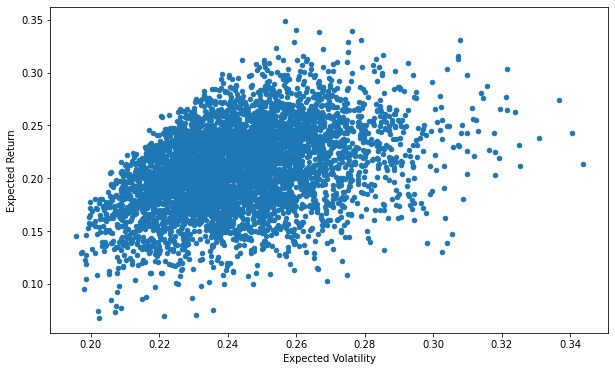

In [162]:
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10, 6));
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.show()

In [163]:
max_return = max(pfolio_returns)
max_return


0.34849890769398323

In [164]:
max_rindex = np.where(pfolio_returns == max_return)
print(max_rindex)

(array([1776]),)


In [165]:
max_rvolatility = pfolio_volatilities[max_rindex[0][0]]
max_rvolatility

0.25678034093268776

In [166]:
max_rweights = pfolio_weights[max_rindex[0][0]]
max_rweights

array([0.29639258, 0.00646334, 0.08655413, 0.07694461, 0.0344442 ,
       0.48418844, 0.01501269])

In [167]:
min_volatility = pfolio_volatilities.min()

min_volatility

0.1956034818091202

In [168]:
min_vindex = np.where(pfolio_volatilities == min_volatility)
min_vindex

(array([2051]),)

In [169]:
min_vreturns = pfolio_returns[min_vindex[0][0]]
min_vreturns

0.1451407455940664

In [170]:
min_vweights = pfolio_weights[min_vindex[0][0]]
min_vweights

array([0.01233508, 0.24192936, 0.23623416, 0.20624487, 0.01495894,
       0.24094257, 0.04735502])

In [171]:
max_sr = []
max_sr =  [str(round(max_return * 100,3) ) + '%', str(round(max_rvolatility * 100,3)) + '%']
for i in range(num_assets):
    max_sr.append(str(round(max_rweights[i] * 100,3)) + '%')
max_sr

['34.85%',
 '25.678%',
 '29.639%',
 '0.646%',
 '8.655%',
 '7.694%',
 '3.444%',
 '48.419%',
 '1.501%']

In [172]:
min_vol = []
min_vol =  [str(round(min_vreturns*100,3)) + '%', str(round(min_volatility * 100,3)) + '%']
for i in range(num_assets):
    min_vol.append(str(round(min_vweights[i] *100,3)) + '%')
min_vol

['14.514%',
 '19.56%',
 '1.234%',
 '24.193%',
 '23.623%',
 '20.624%',
 '1.496%',
 '24.094%',
 '4.736%']

In [173]:
#Max Sharpe Ratio
MaxSharpeRatio = go.Scatter(
    name='Maximium Return',
    mode='markers',
    x=[max_rvolatility],
    y=[max_return],
    marker=dict(color='red',size=14,line=dict(width=3, color='black'))
)

#Min Vol
MinVol = go.Scatter(
    name='Mininium Risk',
    mode='markers',
    x=[min_volatility],
    y=[min_vreturns],
    marker=dict(color='green',size=14,line=dict(width=3, color='black'))
)

#Random portfolio
EF_curve = go.Scatter(
    name='Random Portfolios',
    mode='markers',
    x= pfolio_volatilities,
    y= pfolio_returns,
    marker=dict(color='blue',size=5)
)

data = [MaxSharpeRatio, MinVol, EF_curve]

layout = go.Layout(
    title = 'Portfolio Optimisation with the Efficient Frontier',
    yaxis = dict(title='Annualised Return'),
    xaxis = dict(title='Annualised Volatility'),
    showlegend = True,
    legend = dict(
        x = .75, y = 0, traceorder='normal',
        bgcolor='#E2E2E2',
        bordercolor='black',
        borderwidth=2),
    width=800,
    height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()

### Max Sharpe ratio and Min volatility table with required weights of stocks

In [174]:
col = []
col =  ['Returns', 'Volatility']
for i in range(num_assets):
    col.append(pf_data.columns[i])

In [175]:
result_table = pd.DataFrame(columns  = [col], index=['maximum Return', 'minimun risk'])
result_table.iloc[0] = max_sr
result_table.iloc[1] = min_vol

In [176]:
result_table

,Returns,Volatility,BAJFINANCE.NS,COALINDIA.NS,ITC.NS,KOTAKBANK.NS,NCC.NS,RELIANCE.NS,SBIN.NS
maximum Return,34.85%,25.678%,29.639%,0.646%,8.655%,7.694%,3.444%,48.419%,1.501%
minimun risk,14.514%,19.56%,1.234%,24.193%,23.623%,20.624%,1.496%,24.094%,4.736%


### Correlation Graph

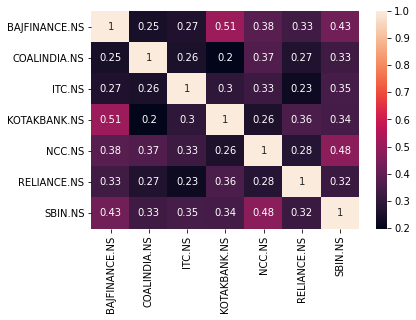

In [177]:
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [178]:
trace = go.Heatmap(
   x = assets,
   y = assets,
   z = corr_matrix,
   type = 'heatmap',
   colorscale = 'Viridis',
   hovertemplate = "%{z}"
)
layout = go.Layout(
    title = 'Correlation',
    yaxis = dict(title='Stocks'),
    xaxis = dict(title='Stocks'),
    showlegend = False,
    width=500,
    height=500)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

# **🙂🙂🙂**